In [ ]:
#Contents
#Introduction to the Notebook
#Introduction to the Dataset
#Exploratory Data Analysis (EDA)
#Introduction to LSTM
#LSTM Input Sequencing
#Handling Incomplete Sequences in Time-Series Forecasting
#LSTM Model Predictions
#Conclusions

In [ ]:
#From Earth to AI: Time Series Prediction of Soil Moisture with LSTM
#I recently acquired a dataset on soil moisture in Germany for the year 2013 from a colleague at Forschungszentrum Julich. The colleague inquired if it's feasible to deploy LSTM on this dataset. Since it's open-source, I decided to give it a shot. I've been meaning to create a beginner friendly notebook on LSTM for a while now. In this notebook, I'll try to explore into the dataset, conduct a thorough exploratory data analysis, and try using the LSTM technique. I hope this will be helpful for others.

In [1]:
# all necessary libraries imported here
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import folium
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
from keras.layers import Dropout
from keras.regularizers import L1L2
from keras.callbacks import EarlyStopping

In [2]:
# Load the data
df = pd.read_csv('D:/SSMDownscaling/NewCodes/Kaggle/updated_data.csv')

# Data overview
print("Dataset Shape:", df.shape)
print("\nFirst 5 rows of the dataset:")
print(df.head())

# Check for missing values
print("\nMissing values in each column:")
print(df.isnull().sum())

# Descriptive statistics
print("\nDescriptive statistics of the dataset:")
print(df.describe())

Dataset Shape: (321584, 8)

First 5 rows of the dataset:
         time  latitude  longitude  clay_content  sand_content  silt_content  \
0  01/03/2013    54.875      9.125             5            86             9   
1  01/05/2013    54.875      9.125             5            86             9   
2  01/07/2013    54.875      9.125             5            86             9   
3  01/08/2013    54.875      9.125             5            86             9   
4  01/09/2013    54.875      9.125             5            86             9   

     sm_aux  sm_tgt  
0  0.454120    0.53  
1  0.437102    0.44  
2  0.412978    0.42  
3  0.378734    0.55  
4  0.350740    0.46  

Missing values in each column:
time            0
latitude        0
longitude       0
clay_content    0
sand_content    0
silt_content    0
sm_aux          0
sm_tgt          0
dtype: int64

Descriptive statistics of the dataset:
            latitude      longitude  clay_content   sand_content  \
count  321584.000000  321584.0000

In [3]:
# Determine unique latitude-longitude pairs
unique_locations = df[['latitude', 'longitude']].drop_duplicates().reset_index(drop=True)
print(f"There are {unique_locations.shape[0]} unique locations in the dataset.")

There are 1166 unique locations in the dataset.


In [5]:
# Create a base map centered around Germany
m = folium.Map(location=[51.1657, 10.4515], zoom_start=5, tiles="OpenStreetMap", width=800, height=800)

# Add unique locations to the map
for idx, row in unique_locations.iterrows():
    folium.CircleMarker(
        location=(row['latitude'], row['longitude']),
        radius=2,
        color='blue',
        fill=True,
        fill_color='blue',
        fill_opacity=0.6
    ).add_to(m)

# Display the map directly
m


In [ ]:
#Surprise Revelation!
#Oh, I thought dataset only encompasses Germany, but I think it goes beyond Germany into Denmark, France, Belgium, and other neighboring European countries. 
#So really, the dataset encompasses many countries in Europe. I didn't know this prior to this plot.

In [6]:
# Create a unique identifier for each location
df['location_id'] = df.groupby(['latitude', 'longitude']).ngroup()
# Determine the start and end of the time series
start_date = df['time'].min()
end_date = df['time'].max()
print(f"The time series starts on {start_date} and ends on {end_date}.")

The time series starts on 01/01/2013 and ends on 12/31/2013.


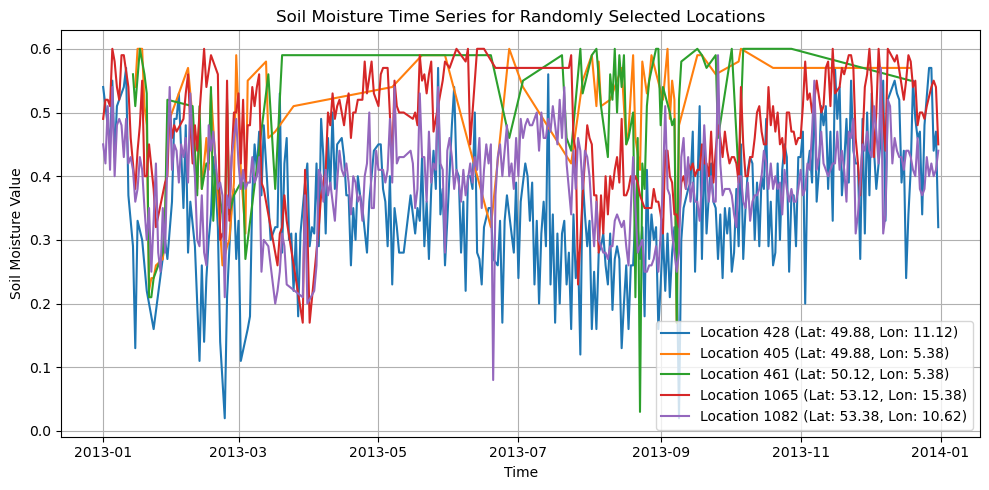

In [7]:
# Randomly select five unique location IDs
random_locations = np.random.choice(df['location_id'].unique(), 5, replace=False)

# Plot time series data for the selected locations
plt.figure(figsize=(10, 5))
for location in random_locations:
    subset = df[df['location_id'] == location]
    lat = subset['latitude'].iloc[0]
    lon = subset['longitude'].iloc[0]
    plt.plot(pd.to_datetime(subset['time']), subset['sm_tgt'], label=f"Location {location} (Lat: {lat:.2f}, Lon: {lon:.2f})")

plt.title("Soil Moisture Time Series for Randomly Selected Locations")
plt.xlabel("Time")
plt.ylabel("Soil Moisture Value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

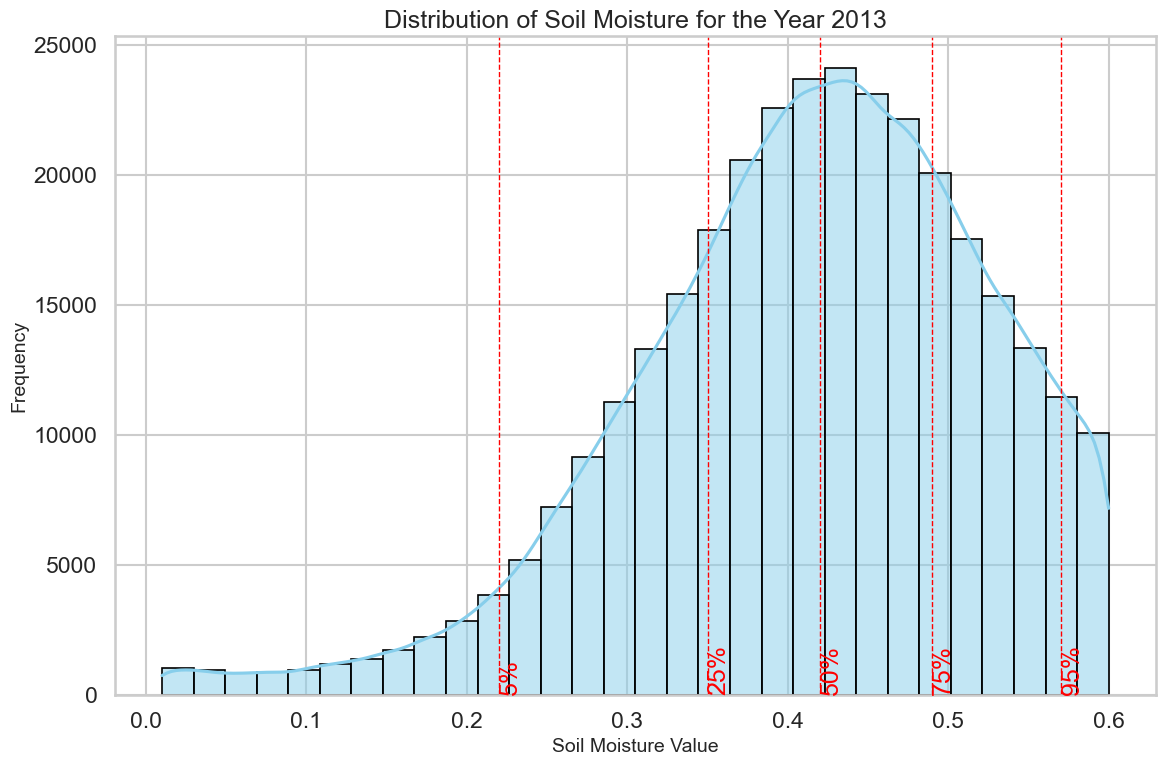

In [8]:
# Set style and context to make the plot look fancy
sns.set_style("whitegrid")
sns.set_context("talk")

# Create the distribution plot
plt.figure(figsize=(12, 8))
sns.histplot(df['sm_tgt'], kde=True, bins=30, color='skyblue', edgecolor='black', linewidth=1.2)

# Mark percentiles on the plot
percentiles = [5, 25, 50, 75, 95]
for percentile in percentiles:
    value = np.percentile(df['sm_tgt'], percentile)
    plt.axvline(value, color='red', linestyle='dashed', linewidth=1)
    plt.text(value, 5, f'{percentile}%', color='red', rotation=90, verticalalignment='bottom')

# Set the title and labels
plt.title("Distribution of Soil Moisture for the Year 2013", fontsize=18)
plt.xlabel("Soil Moisture Value", fontsize=14)
plt.ylabel("Frequency", fontsize=14)

plt.tight_layout()
plt.show()


In [ ]:
#What we see in Histogram
#Less than 5% of soil moisture values indicate very dry conditions.
#Below 20% of the data points show soil moisture values that can be categorized as somewhat low, with a threshold of 0.25 differentiating between sufficiently irrigated and not sufficiently irrigated regions.
#A significant proportion, more than 50%, of the land has soil moisture values below 40%, highlighting potential areas of concern.
#These observations shed light on the distribution and potential challenges related to soil moisture in the studied regions for the year 2013.

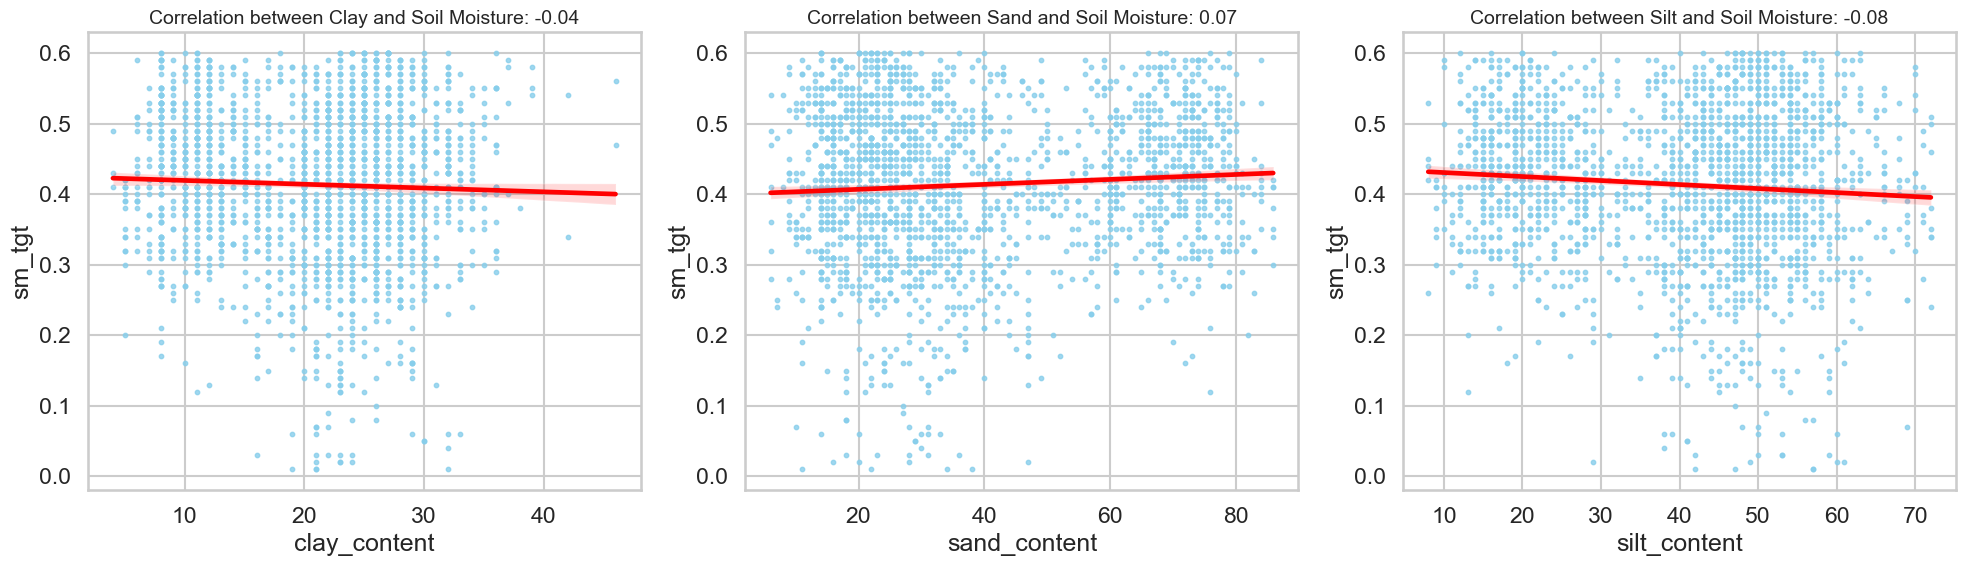

In [9]:
# Randomly sample 2000 data points from the dataframe
sample_df = df.sample(n=2000, random_state=42)

# Set the aesthetic style of the plots
sns.set_style("whitegrid")
sns.set_context("talk")

# Initialize a figure with three subplots side by side
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 6))

# List of soil components
components = ['clay_content', 'sand_content', 'silt_content']

# Plot scatter plots for each component
for i, component in enumerate(components):
    sns.regplot(x=component, y='sm_tgt', data=sample_df, ax=axes[i], color='skyblue', scatter_kws={'s':10}, line_kws={'color':'red'})
    
    # Calculate correlation and annotate the plot with its value
    correlation = sample_df[component].corr(sample_df['sm_tgt'])
    axes[i].set_title(f"Correlation between {component.split('_')[0].capitalize()} and Soil Moisture: {correlation:.2f}", fontsize=14)

# Adjust layout for better display
plt.tight_layout()
plt.show()

In [ ]:
#########Soil Composition vs. Soil Moisture: Observations
#The correlation plots do not indicate any strong relationships between soil composition and soil moisture.
#There are very weak trends (red lines) observed (not to be considered seriously):
#Higher clay content is associated with lower soil moisture.
#Higher sand content seems to correspond with greater soil moisture.
#Increased silt content is related to reduced soil moisture.
#The data appears scattered without a clear directional trend, suggesting that soil moisture may not be predominantly influenced by soil type alone.
#Given the dataset's origin from Europe, where many agricultural areas benefit from automated irrigation systems, the lack of a clear trend may hint at the impact of artificial irrigation.
#It's crucial to note that the plots were generated using a random sample of 2000 data points from the extensive dataset to conserve computational resources that Kaggle genourously gives us!
#In summary, the data suggests that while there are weak trends between soil type and moisture, other factors, possibly artificial irrigation, play a significant role in determining soil moisture levels.

In [ ]:
#####Introduction to LSTM
https://www.kaggle.com/code/sathyanarayanrao89/lstm-for-soil-moisture-prediction?scriptVersionId=145212234&cellId=17

#he Bike Ride from Point A to Point B: RNN vs. LSTM
Imagine you took a bike ride from Point A to Point B, a journey filled with various experiences.

Major Events:
Starting at Point A, you felt the morning chill.
Midway, you stopped at a cafe and had a memorable conversation with a stranger.
You crossed a beautiful bridge with a river flowing beneath.
Finally, you reached Point B just in time to witness a breathtaking sunset.
Minor Details:
The song playing in the cafe.
A bird you saw while crossing the bridge.
The brand of a passing bike.
Illustration
Now, let's relate this to neural networks:

Recurrent Neural Networks (RNNs):
RNNs are like a quick journal entry. They'll note down the major events: starting at Point A, the cafe stop, crossing the bridge, and arriving at Point B. However, as the journey progresses, the earlier details, like the morning chill, might get overshadowed by the sunset at Point B.

Long Short-Term Memory (LSTM):
LSTMs are like a detailed travel diary. They'll remember the major events and also some of the minor details.

The Forget Gate might decide that the song in the cafe, while nice, isn't as crucial to the journey's narrative.
The Input Gate might choose to remember the bird on the bridge because it added to the beauty of that moment.
The Output Gate will use these memories to provide a comprehensive recount of the journey, ensuring both the sunrise at Point A and the sunset at Point B are given importance.
The Motorcycle Ride of Understanding LSTM
Illustration
The Context:
The previous hidden state,  ht−1
 , and cell state,  ct−1
 , set the context, like recalling the last landmark on your journey.
Forget Gate:
As you continue, the forget gate determines which memories to keep and which to discard.
Input Gate:
This gate decides new experiences to store, like noting an important point on your route.
Memory Update:
The gates work together to update your long-term memory or the cell state.
Output Gate:
The output gate uses the long-term memory to create the current hidden state,  ht
 , which represents your current thoughts.
Regulation:
The sigmoid and tanh functions help regulate the memories and thoughts, keeping them balanced. Acting as our motorcycle's brakes and throttle, ensuring the memories and thoughts are balanced, preventing a skid or a burnout. Technically known as 💥💥gradient explosion💥💥 or vanising problem.
#ike the processes in a motorcycle ride, the LSTM cell effectively handles data. As we prepare to use LSTM on our soil moisture data, we need to set up our input sequences for the model to work efficiently.

In [ ]:
# https://www.kaggle.com/code/sathyanarayanrao89/lstm-for-soil-moisture-prediction#For more details about such explanations

In [ ]:
#Input Sequencing
#Crafting Input Sequences for LSTM Modeling
#When working with agricultural/hydrological data, gaps and missing values can pose challenge to train ML models. To tackle this, we've adopted a strategy for preparing our LSTM model.
#Steps for Input Sequencing:
#June Data Extraction: Instead of using the typical last-month split for testing, we've taken out June's data, simulating real-world data gaps.
# Choosing a Sequence Length: We will decide a sequence length, meaning our model will use data from say 30 preceding days to predict the next day's soil moisture.
# Data Normalization: Essential for LSTM models to yield optimal results. Columns like latitude, longitude, and soil components should be normalized using the MinMaxScaler.
#Sequence Creation: After sorting and grouping, sequences should be generated for each location. Each 30-day sequence of data will be paired with the correct subsequent day's soil moisture target.

In [10]:
#Remove June Data to Simulate Data Gap
# Convert the 'time' column to datetime format
df['time'] = pd.to_datetime(df['time'])

# Separate the data for June
june_data = df[df['time'].dt.month == 6]

# Remove June data from the main dataframe
df = df[df['time'].dt.month != 6]

june_data.head()

,time,latitude,longitude,clay_content,sand_content,silt_content,sm_aux,sm_tgt,location_id
96,2013-06-01,54.875,9.125,5,86,9,0.132296,0.35,1163
97,2013-06-02,54.875,9.125,5,86,9,0.111909,0.31,1163
98,2013-06-03,54.875,9.125,5,86,9,0.099585,0.32,1163
99,2013-06-04,54.875,9.125,5,86,9,0.081596,0.32,1163
100,2013-06-05,54.875,9.125,5,86,9,0.098436,0.31,1163


In [ ]:
#Create Input Sequencing
#LSTM use gradient descent to update the network weights during training. Features that have a larger scale can dominate the cost function and make the optimization process more challenging, leading to longer training times and a model that might not converge. 
#Hence in the next step we use MinMaxScaler to scale our data

In [11]:
# Features to normalize
features_to_normalize = ['latitude', 'longitude', 'clay_content', 'sand_content', 'silt_content', 'sm_aux', 'location_id','sm_tgt']

# Initialize scaler
scaler = MinMaxScaler()

# Apply normalization to the dataframe (both training and June data)
df[features_to_normalize] = scaler.fit_transform(df[features_to_normalize])
june_data[features_to_normalize] = scaler.transform(june_data[features_to_normalize])

# Reorder the columns to ensure 'sm_tgt' is the last column
ordered_columns = ['time', 'latitude', 'longitude', 'clay_content', 'sand_content', 'silt_content', 'sm_aux', 'location_id', 'sm_tgt']
df = df[ordered_columns]
june_data = june_data[ordered_columns]

df.head()

,time,latitude,longitude,clay_content,sand_content,silt_content,sm_aux,location_id,sm_tgt
0,2013-01-03,1.0,0.509091,0.02381,1.0,0.015625,0.585957,0.999141,0.881356
1,2013-01-05,1.0,0.509091,0.02381,1.0,0.015625,0.565721,0.999141,0.728814
2,2013-01-07,1.0,0.509091,0.02381,1.0,0.015625,0.537036,0.999141,0.694915
3,2013-01-08,1.0,0.509091,0.02381,1.0,0.015625,0.496316,0.999141,0.915254
4,2013-01-09,1.0,0.509091,0.02381,1.0,0.015625,0.463029,0.999141,0.762712


In [12]:
june_data.head()

,time,latitude,longitude,clay_content,sand_content,silt_content,sm_aux,location_id,sm_tgt
96,2013-06-01,1.0,0.509091,0.02381,1.0,0.015625,0.203279,0.999141,0.576271
97,2013-06-02,1.0,0.509091,0.02381,1.0,0.015625,0.179037,0.999141,0.508475
98,2013-06-03,1.0,0.509091,0.02381,1.0,0.015625,0.164383,0.999141,0.525424
99,2013-06-04,1.0,0.509091,0.02381,1.0,0.015625,0.142992,0.999141,0.525424
100,2013-06-05,1.0,0.509091,0.02381,1.0,0.015625,0.163016,0.999141,0.508475


In [ ]:
#One common method to create input sequences for LSTM is the "sliding window" approach. For a given time step of n, you'd use the values from t-1, t-2, ... t-n to predict t. Then, you slide the window one step forward and use t, t-1, ... t-(n-1) to predict t+1, and so on.
#Handling Incomplete Sequences in Time-Series Forecasting
#The Context:
#In LSTM forecasting, the consistency and completeness of sequences are pivotal. Incomplete sequences can lead to inaccurate training and misleading predictions.
#Identifying Incomplete Sequences:
#Analyze the dataset to pinpoint any sequences (e.g., locations) with inadequate data. For instance, for monthly data forecasting with a 15-day sequence length, any location with fewer than 15 days of data for a given month might be deemed incomplete and should either be padded or removed.
#Deciding on Sequence Length:
#The length of the sequence is fundamental in LSTM-based forecasting. A longer sequence can capture more patterns but needs more data. Conversely, a shorter sequence might miss long-term patterns but is more flexible with datasets having sporadic missing values.
#Filtering Out Incomplete Sequences:
#After determining an appropriate sequence length, filter out sequences that don't meet this criterion. This ensures the LSTM model is fed with consistent input.
#Rationale:
#LSTMs rely on consistent sequence lengths to discern and learn time-series data patterns. Inputting incomplete sequences can disrupt their learning capability, leading to suboptimal performance.

In [13]:
# Calculate the number of data points for each location in june_data
data_points_per_location = june_data.groupby('location_id').size()

# Identify locations with less than 15 days of data
locations_to_exclude = data_points_per_location[data_points_per_location < 15].index

# Filter out these locations from june_data
june_data = june_data[~june_data['location_id'].isin(locations_to_exclude)]

In [14]:
def create_sequences(data, seq_length):
    """
    Create input-output sequence pairs from the provided dataframe.
    """
    X, Y = [], []

    for location, group in data.groupby('location_id'):
        # Extract relevant features from the group
        features = group[features_to_normalize].drop(columns='sm_tgt').values
        targets = group['sm_tgt'].values
        
        # Create sequences
        for i in range(len(features) - seq_length):
            X.append(features[i:i+seq_length])
            Y.append(targets[i+seq_length])
            
    return X, Y

# Define the sequence length (30 days)
seq_length = 15

# Create sequences for training data
X, Y = create_sequences(df, seq_length)

# Convert lists to numpy arrays for easier handling later
X = np.array(X)
Y = np.array(Y)

X.shape, Y.shape

((277893, 15, 7), (277893,))

In [ ]:
#LSTM Model

Epoch 1/10
1737/1737 [==============================] - 85s 48ms/step - loss: 0.0693 - val_loss: 0.0318
Epoch 2/10
1737/1737 [==============================] - 104s 60ms/step - loss: 0.0313 - val_loss: 0.0260
Epoch 3/10
1737/1737 [==============================] - 93s 54ms/step - loss: 0.0295 - val_loss: 0.0316
Epoch 4/10
1737/1737 [==============================] - 92s 53ms/step - loss: 0.0288 - val_loss: 0.0300
Epoch 5/10
1737/1737 [==============================] - 83s 48ms/step - loss: 0.0284 - val_loss: 0.1172
Epoch 5: early stopping


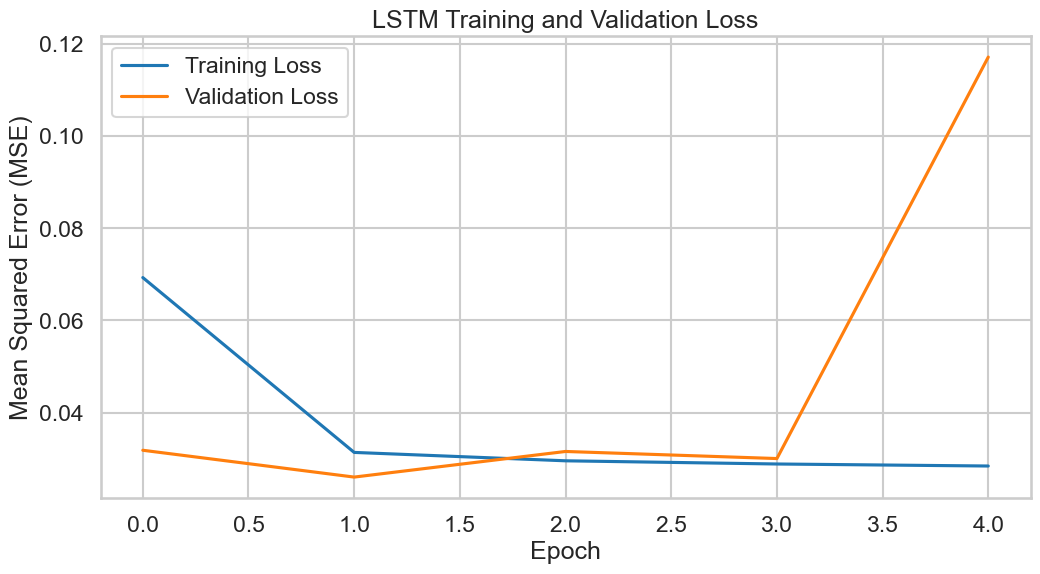

In [15]:
from keras.models import Sequential
from keras.layers import LSTM, BatchNormalization, Dropout, Dense
from keras.regularizers import l2

model = Sequential()
model.add(LSTM(75, activation='relu', input_shape=(X.shape[1], X.shape[2]), kernel_regularizer=l2(0.01), recurrent_regularizer=l2(0.01), return_sequences=True))
model.add(LSTM(75, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.4))
# Dense output layer
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# Define early stopping callback
early_stop = EarlyStopping(monitor='val_loss', patience=3, verbose=1, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(X, Y, epochs=10, batch_size=128, validation_split=0.2, verbose=1, callbacks=[early_stop])

# Plot the training and validation loss

plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('LSTM Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error (MSE)')
plt.legend()
plt.grid(True)
plt.show()

In [16]:
X_june, Y_june_true = create_sequences(june_data, seq_length)
X_june = np.array(X_june);
Y_june_true = np.array(Y_june_true);
model.compile(optimizer='adam', loss='mse');
X_june.shape,Y_june_true.shape

((10158, 15, 7), (10158,))

In [17]:
predictions = model.predict(X_june,batch_size=128)

80/80 [==============================] - 1s 12ms/step


In [18]:
def reverse_scaling(data, scaler):
    """
    Reverse the scaling effect on data.
    """
    # Convert data to a 2D array if it's 1D
    if len(data.shape) == 1:
        data = data.reshape(-1, 1)
    
    dummy = np.zeros((len(data), len(features_to_normalize)))
    
    # Set the last column of the dummy array to your data
    dummy[:, -1] = data.ravel()
    
    # Use inverse_transform to reverse the scaling
    unscaled = scaler.inverse_transform(dummy)
    
    # Return the last column (our actual unscaled data)
    return unscaled[:, -1]

In [19]:
# Reverse scaling for Y_june_true and predictions
Y_june_true_unscaled = reverse_scaling(Y_june_true, scaler)
predictions_unscaled = reverse_scaling(predictions, scaler)

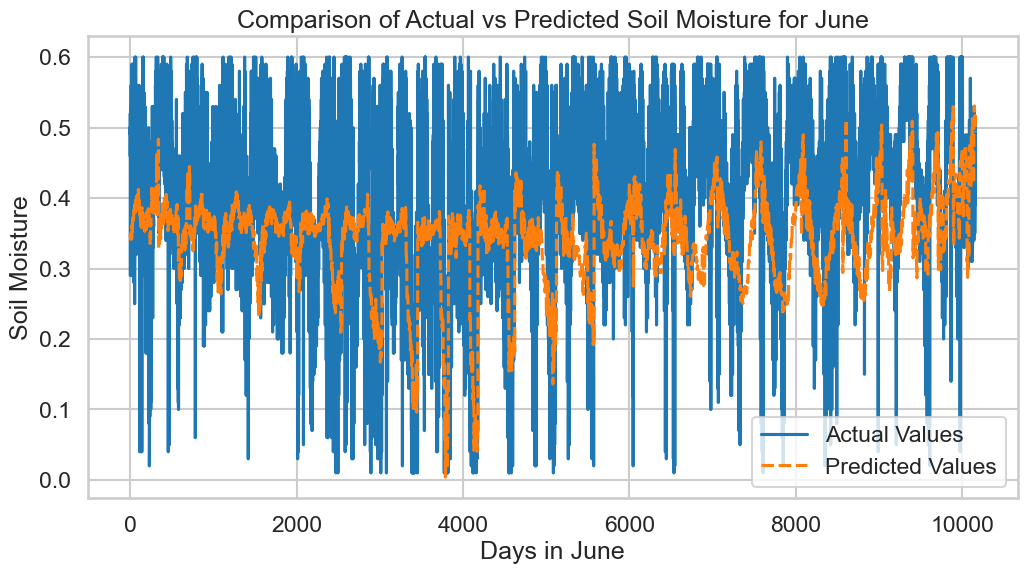

In [20]:
# Ensure both arrays are 1-dimensional
Y_june_true_unscaled = Y_june_true_unscaled.ravel()
predictions_unscaled = predictions_unscaled.ravel()

# Create a DataFrame for plotting
df_plot = pd.DataFrame({
    'Actual Values': Y_june_true_unscaled,
    'Predicted Values': predictions_unscaled
})

# Set Seaborn style
sns.set_style("whitegrid")

# Create a line plot
plt.figure(figsize=(12, 6))
sns.lineplot(data=df_plot)
plt.title('Comparison of Actual vs Predicted Soil Moisture for June')
plt.ylabel('Soil Moisture')
plt.xlabel('Days in June')
plt.legend()
plt.show()

In [21]:
# Calculate MAE
mae = np.mean(np.abs(Y_june_true_unscaled - predictions_unscaled))
print(f"Mean Absolute Error for June Predictions: {mae}")

Mean Absolute Error for June Predictions: 0.10389910270573824


In [ ]:
#Conclusion: Taking Baby Steps with LSTM
#What We Achieved:
#We built an LSTM model and got an error score of 0.06 to 0.07. This means our model is doing something right!
#Our model seems to "get" the bigger picture of soil moisture data trend, even if it misses some small details. There is definetly room to improve it by incorporating L1 or L2 regularization, playing with batch size or epochs etc.
#What's Next?
#But remember, our main goal was to show how LSTMs can work even when some data is missing. And we did that!
#Final Thoughts:
#This notebook is like a first step in a big journey of Nueral Networks. We learned, we tried, and we saw some cool stuff (I hope). There's more out there!
#Thank you for joining me on this ride! See you again with a new notebook